In [ ]:
#@title
!pip install https://github.com/qb-0/PyMeow/releases/download/1.7/1.7.zip
!pip install pyautogui
!pip install keyboard
!pip install opencv-python 
!pip install pillow
!pip install gym

  Created wheel for pymeow: filename=pymeow-1.7-py3-none-any.whl size=726930 sha256=9417ed53dc5fc8807792d59cbae44ee74539130108ff94b5f2f28e1216c89058
  Stored in directory: C:\Users\Thomas\AppData\Local\Temp\pip-ephem-wheel-cache-nxjbh79v\wheels\d2\69\47\2b6192690895fa281b840d70a3e767c2a0eefe95b91e0cf41c
Successfully built pymeow


In [ ]:
from pymeow import *
import pyautogui
import keyboard
import time
import random
import numpy as np 
import matplotlib.pyplot as plt
import gym
from gym import Env, spaces
import PIL.ImageGrab
from collections import deque
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

C:\Users\Thomas\anaconda3\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [ ]:
# this checks the memory offsets
def read_offsets(proc, base_address, offsets):
    basepoint = read_int64(proc, base_address)

    current_pointer = basepoint
    
    for i in offsets[:-1]:
        current_pointer = read_int64(proc, current_pointer+i)

    return current_pointer + offsets[-1]

In [ ]:
def init_address():
    # Using addresses and offsets to read memory
    round_addr = read_offsets(process, round_base_address, round_offsets)
    
    return round_addr

In [ ]:
# actually reads what is at the address
def get_address_values(round_addr):
    round_value = read_int(process, round_addr)
    return round_value

In [ ]:
# this calculates the current cash based off of what is earned each round and what has been spent
def get_cash(round, cash_spent):
  current_cash = 650
  for i in range(round - 1):
    current_cash += round_cash[i]

  current_cash -= cash_spent
  return current_cash

In [ ]:
# a Tower object representing a tower in game uses inputed data for its attributes seen below
class Tower:
    
    base_cost = 0
    upgrade_costs = [[]]
    hotkey = ""
    upgrades = []
    x_location = 0
    y_location = 0
    
    def __init__(self, base_cost, upgrade_costs, hotkey, upgrades):
        self.base_cost = base_cost
        self.upgrade_costs = upgrade_costs
        self.hotkey = hotkey
        self.upgrades = upgrades

    def set_location(self, x, y):
        self.x_location = x
        self.y_location = y

In [ ]:
# function that makes use of the Tower class and creates a new objects and puts it in the list
def create_tower(cost, upgrade_costs, hotkey, x, y, tower_dict, tower_num, init_upgrades):
    env.tower_num += 1
    new_tower = Tower(cost, upgrade_costs, hotkey, init_upgrades)
    new_tower.set_location(x, y)
    env.tower_dict[tower_num] = new_tower

In [ ]:
# this function will take place before the create_tower above and takes care of the placing of the tower
# once the tower is placed a Tower object is created
def place_tower(cost, upgrade_costs, hotkey, x, y, tower_dict, tower_num, init_upgrades):
    # use the hotkey for the tower and the mouse to use and move tower 
    keyboard.press_and_release(hotkey)
    pyautogui.moveTo(x, y)
    placeable = False
    time.sleep(1.5)
    
    while True:
        # this if is to stop the program and will need to be held for a while
        if keyboard.is_pressed("1"):
            break
        
        # uses the check_pixel function below to know if the tower is placeable at this location
        placeable = check_pixel()
        # check_pixel returns false when there is not a red pixel/when the tower is placeable
        if not placeable:
            pyautogui.click()
            x,y = pyautogui.position()
            break
        # nudge moves the cursor slightly in a random direction to get the tower to a placeable location
        pyautogui.moveRel(nudge())
        x,y = pyautogui.position()
        # if statements ensure that the cursor does not go out of bounds
        if x > 1058:
            x -= 20
        elif x < 111:
            x += 20
        if y > 660:
            y -= 20
        elif y < 137:
            y += 20
            
    
    create_tower(cost, upgrade_costs, hotkey, x, y, env.tower_dict, env.tower_num, init_upgrades)

In [ ]:
# This is for checking if there is a pure red pixel around the cursor when placing a tower
# If there is a red pixel this means that the tower is not placeable and will need to be moved again
def check_pixel():
    x,y = pyautogui.position()
    image = PIL.ImageGrab.grab(bbox=((x-30), (y-30), (x+30), (y+30)))
    for y in range(0, 60, 1):
        for x in range(0, 60, 1):
            color = image.getpixel((x, y))
            if color == (255, 0, 0):
                return True
            
    return False

In [ ]:
# "nudges" the cursor to get it to place a tower relative to the initially chose position
def nudge():
    up_down = random.randint(-20, 20)
    left_right = random.randint(-20, 20)
    return  left_right, up_down

In [ ]:
# this function is for upgrading towers
def upgrade_tower(tower_index, tower_dict, path, current_cash):
    
    # these are the hotkeys for upgrading a tower
    path_1_hotkey = ","
    path_2_hotkey = "."
    path_3_hotkey = "/"
    
    # because Tower objects are stored in a dictionary the need to be gotten out to be easily accessed
    tower = tower_dict[tower_index]
    x = tower.x_location
    y = tower.y_location

    spent_cash = 0
    
    # what the below statements do is check if the path that is trying to be upgraded is possible to be upgraded and if there is enough money for it
    if path == 1:
        if tower.upgrades[0] < 5 and tower.upgrades[1] < 3 and tower.upgrades[2] < 3:
            if current_cash >= tower.upgrade_costs[0][tower.upgrades[0]]:
                pyautogui.click(x, y)
                time.sleep(0.5)
                keyboard.press_and_release(path_1_hotkey)
                tower.upgrades[0] += 1
                pyautogui.click()
                spent_cash = tower.upgrade_costs[0][tower.upgrades[0]]
    
    elif path == 2:
        if tower.upgrades[0] < 3 and tower.upgrades[1] < 5 and tower.upgrades[2] < 3:
            if current_cash >= tower.upgrade_costs[1][tower.upgrades[1]]:
                pyautogui.click(x, y)
                time.sleep(0.5)
                keyboard.press_and_release(path_2_hotkey)
                tower.upgrades[1] += 1
                pyautogui.click()
                spent_cash = tower.upgrade_costs[1][tower.upgrades[1]]
            
    elif path == 3:
        if tower.upgrades[0] < 3 and tower.upgrades[1] < 3 and tower.upgrades[2] < 5:
            if current_cash >= tower.upgrade_costs[2][tower.upgrades[2]]:
                pyautogui.click(x, y)
                time.sleep(0.5)
                keyboard.press_and_release(path_3_hotkey)
                tower.upgrades[2] += 1
                pyautogui.click()
                spent_cash = tower.upgrade_costs[2][tower.upgrades[2]]

    return spent_cash
        

In [ ]:
# this is the environment
class BloonsPlayer(Env):
    
    round_addr = 0
    tower_dict = {}
    tower_num = 0
    init_upgrades = [0, 0, 0]
    current_cash = 650
    spent_cash = 0
    
    def __init__(self):
        super(BloonsPlayer, self).__init__()
        
        # the actual value for the action_space does not really matter
        self.observation_space = spaces.Tuple((spaces.Box(low=0, high=999999, shape=(1,)), spaces.Box(low=6, high=100, shape=(1,))))
        self.action_space = spaces.Discrete(80)
        
    def reset(self):
        self.ep_return = 0
        
        # these are the bounds of the placeable area I want allowed on logs based off of my resolution
        rand_x = random.randint(111, 1058)
        rand_y = random.randint(137, 660)
        
        self.tower_dict = {}
        self.tower_num = 0
        self.init_upgrades = [0, 0, 0]
        
        index = 0
        
        self.round_addr = init_address()
        self.current_cash = 650
        self.spent_cash = 0

        current_env = [self.current_cash, get_address_values(round_addr)]
        current_env = np.array(current_env)
        return current_env
        
    def step(self, action):
        done = False

        # get the current cash
        self.current_cash = get_cash(self.ep_return, self.spent_cash)
        
        reward = 1
        
        rand_x = random.randint(111, 1058)
        rand_y = random.randint(137, 660)
        
        # actions 1-19 refer to towers
        if action in range(1, 19):
            if base_cost_list[action-1] < self.current_cash:
                place_tower(base_cost_list[action-1], upgrade_cost_list[action-1], hotkey_list[action-1], rand_x, rand_y, self.tower_dict, self.tower_num, self.init_upgrades)
                self.spent_cash += base_cost_list[action-1]
        
        # actions above 19 refer to upgrades of placed towers
        # the way actions work will be described below where they are used
        if action > 19:
            var1 = 20
            var2 = 21
            var3 = 22
            for i in range(len(self.tower_dict)):
                if action in [var1, var2, var3]:
                    tower = self.tower_dict[i]
                    if action == var1:
                        path = 1
                        self.spent_cash += upgrade_tower(i, self.tower_dict, path, self.current_cash)
                    
                    elif action == var2:
                        path = 2
                        self.spent_cash += upgrade_tower(i, self.tower_dict, path, self.current_cash)
                        
                    elif action == var3:
                        path = 3
                        self.spent_cash += upgrade_tower(i, self.tower_dict, path, self.current_cash)
                        
                var1+=3
                var2+=3
                var3+=3
        
        self.ep_return += 1
            
        current_env = [self.current_cash, get_address_values(round_addr)]
        current_env = np.array(current_env)
            
        return current_env, reward, done, []
            

In [ ]:
def select_action(current_exploration_rate, observation, dqn_agent):
    
    rand_num = random.random()

    choices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    # the initial choices are the towers and to do nothing (when 0)
    # the "num" var below gets used when there are towers already placed and in the tower_dict and it will add to the choices the number of possible upgrades
    # each tower can have three available upgrades for purchase right now so three choices get added for every tower in the dict

    # if the random number is less than exploration rate then a take random action 
    if rand_num <= current_exploration_rate:
      tower_dict = env.tower_dict
      num = 20
      for i in range(len(tower_dict)):
        choices.append(num)
        choices.append(num + 1)
        choices.append(num + 2)
        num+=3
      
      action = np.random.choice(choices)  

    # otherwise exploit
    else: 
      action = np.argmax(dqn_agent.predict(observation)[0])

    return action 

In [ ]:
def replay(memory, dqn_agent, target_agent, batch_size, gamma):
  
    states_batch = [] 
    q_values_batch = []

    minibatch = random.sample(memory, batch_size)
    for current_observation,action, reward, observation_next, done in minibatch: 
      
      # look at the future
      if not done:
        target = reward + gamma* np.amax(target_agent.predict(observation_next)[0])
      else: 
        target = reward 

      # get the q value for the action taken
      current_q = dqn_agent.predict(current_observation)
      # based off of the action update the q value
      current_q[0][action] = target 

      states_batch.append(current_observation[0])
      q_values_batch.append(current_q[0])

    states_batch = np.array(states_batch)
    q_values_batch = np.array(q_values_batch)

    # use the minibatch to train
    dqn_agent.fit(states_batch, q_values_batch, epochs=1, verbose=0)

    return dqn_agent 

In [ ]:
# this code allows the get_addresses, read_offsets, and init_address to work

# Process name
process = process_by_name("BloonsTD6.exe")

# Base Addresses
round_base_address = process["modules"]["GameAssembly.dll"]["baseaddr"] + 0x02259238

# Offsets
round_offsets = [0xB8, 0x0, 0x180, 0x68, 0x28, 0x20, 0x20]


In [ ]:
# the following code is the upgrade prices of all paths of each tower along with their base cost and their hotkey

dart_monkey_upgrades = [[150, 235, 325, 1945, 16200],
                       [110, 205, 430, 8640, 48600],
                       [95, 215, 675, 2160, 25380]]

dart_monkey_cost = 215
dart_monkey_hotkey = "q"

boomerang_monkey_upgrades = [[215, 300, 1405, 3240, 34990],
                            [190, 270, 1565, 4535, 37800],
                            [110, 325, 1405, 2375, 54000]]

boomerang_monkey_cost = 350
boomerang_monkey_hotkey = "w"

bomb_shooter_upgrades = [[380, 700, 1295, 3890, 59400],
                        [270, 430, 1190, 3455, 27000],
                        [215, 325, 865, 3025, 37800]]

bomb_shooter_cost = 565
bomb_shooter_hotkey = "e"

tack_shooter_upgrades = [[160, 325, 650, 3780, 48140],
                        [110, 245, 595, 2915, 16200],
                        [110, 110, 485, 3455, 21600]]

tack_shooter_cost = 300
tack_shooter_hotkey = "r"

ice_monkey_upgrades = [[110, 380, 1620, 2375, 30240],
                      [245, 380, 3130, 3240, 21600],
                      [190, 245, 2105, 2970, 32400]]

ice_monkey_cost = 540
ice_monkey_hotkey = "t"


glue_gunner_upgrades = [[215, 325, 2700, 5400, 23760],
                       [110, 1945, 3510, 3780, 16200],
                       [130, 430, 3670, 3240, 30240]]

glue_gunner_cost = 295
glue_gunner_hotkey = "y"

sniper_monkey_upgrades = [[380, 1620, 3240, 5400, 36720],
                         [325, 485, 3455, 7775, 14040],
                         [430, 430, 3780, 4590, 25120]]

sniper_monkey_cost = 380
sniper_monkey_hotkey = "z"

monkey_sub_upgrades = [[140, 540, 540, 2700, 34560],
                      [485, 325, 1510, 14040, 34560],
                      [485, 1080, 1190, 3240, 2700]]

monkey_sub_cost = 351
monkey_sub_hotkey = "x"

monkey_buccaneer_upgrades = [[380, 595, 3185, 7775, 27000],
                            [595, 540, 970, 4860, 22680],
                            [195, 430, 2485, 5940, 24840]]

monkey_buccaneer_cost = 541
monkey_buccaneer_hotkey = "c"

monkey_ace_upgrades = [[700, 700, 1080, 3240, 43200],
                      [215, 380, 970, 19440, 32400],
                      [540, 325, 2375, 25920, 91800]]

monkey_ace_cost = 865
monkey_ace_hotkey = "v"

heli_pilot_upgrades = [[865, 540, 1890, 21170, 48600],
                      [325, 650, 3240, 12960, 32400],
                      [270, 380, 3780, 9180, 37800]]

heli_pilot_cost = 1730
heli_pilot_hotkey = "b"

mortar_monkey_upgrades = [[540, 540, 970, 8640, 30240],
                         [325, 540, 970, 5940, 32400],
                         [215, 540, 755, 11880, 43200]]

mortar_monkey_cost = 810
mortar_monkey_hotkey = "n"

dartling_gunner_upgrades = [[325, 970, 4590, 11880, 86400],
                           [270, 1025, 5670, 5510, 64800],
                           [160, 1295, 3670, 12960, 62640]]

dartling_gunner_cost = 920
dartling_gunner_hotkey = "m"

wizard_monkey_upgrades = [[160, 485, 1405, 10800, 34560],
                         [325, 1025, 3240, 4320, 58320],
                         [325, 325, 1835, 3025, 28620]]

wizard_monkey_cost = 405
wizard_monkey_hotkey = "a"

super_monkey_upgrades = [[2700, 3240, 21600, 108000, 540000],
                        [1080, 1510, 8640, 20520, 97200],
                        [3240, 1295, 6050, 64800, 216000]]

super_monkey_cost = 2700
super_monkey_hotkey = "s"

ninja_monkey_upgrades = [[325, 380, 920, 2970, 37800],
                        [380, 540, 970, 5615, 23760],
                        [270, 430, 2970, 4860, 43200]]

ninja_monkey_cost = 542
ninja_monkey_hotkey = "d"

alchemist_upgrades = [[270, 380, 1350, 3240, 64800],
                     [270, 515, 3240, 4860, 48600],
                     [700, 485, 1080, 2970, 43200]]

alchemist_cost = 595
alchemist_hotkey = "f"

druid_upgrades = [[270, 1080, 1780, 4860, 70200],
                 [270, 380, 1025, 5400, 37800],
                 [110, 325, 650, 2700, 48600]]

druid_cost = 430
druid_hotkey = "g"

spike_factory_upgrades = [[865, 650, 2485, 10260, 162000],
                         [650, 865, 2700, 5400, 43200],
                         [160, 430, 1510, 3780, 32400]]

spike_factory_cost = 1080
spike_factory_hotkey = "j"

monkey_village_upgrades = [[430, 1620, 865, 2700, 27000],
                          [270, 2160, 8100, 21600, 43200],
                          [540, 540, 10800, 3240, 5400]]

monkey_village_cost = 1295
monkey_village_hotkey = "k"

engineer_monkey_upgrades = [[540, 430, 620, 2700, 34560],
                           [270, 380, 920, 14580, 113400],
                           [485, 235, 540, 3780, 58320]]

engineer_monkey_cost = 431
engineer_monkey_hotkey = "l"


In [ ]:
# makes lists out of above information
# buccaneer and sub are omitted

base_cost_list = [dart_monkey_cost, boomerang_monkey_cost, bomb_shooter_cost, tack_shooter_cost, ice_monkey_cost, glue_gunner_cost, sniper_monkey_cost,
                 monkey_ace_cost, heli_pilot_cost, mortar_monkey_cost, dartling_gunner_cost, wizard_monkey_cost,
                 super_monkey_cost, ninja_monkey_cost, alchemist_cost, druid_cost, spike_factory_cost, monkey_village_cost, engineer_monkey_cost]

upgrade_cost_list = [dart_monkey_upgrades, boomerang_monkey_upgrades, bomb_shooter_upgrades, tack_shooter_upgrades, ice_monkey_upgrades, glue_gunner_upgrades,
                     sniper_monkey_upgrades, monkey_ace_upgrades, heli_pilot_upgrades, mortar_monkey_upgrades, 
                     dartling_gunner_upgrades, wizard_monkey_upgrades, super_monkey_upgrades, ninja_monkey_upgrades, alchemist_upgrades, druid_upgrades, 
                     spike_factory_upgrades, monkey_village_upgrades, engineer_monkey_upgrades]

hotkey_list = [dart_monkey_hotkey, boomerang_monkey_hotkey, bomb_shooter_hotkey, tack_shooter_hotkey, ice_monkey_hotkey, glue_gunner_hotkey,
                     sniper_monkey_hotkey, monkey_ace_hotkey, heli_pilot_hotkey, mortar_monkey_hotkey, 
                     dartling_gunner_hotkey, wizard_monkey_hotkey, super_monkey_hotkey, ninja_monkey_hotkey, alchemist_hotkey, druid_hotkey, 
                     spike_factory_hotkey, monkey_village_hotkey, engineer_monkey_hotkey]

In [ ]:
# this is used by get_current_cash
round_cash = [163, 182, 200, 199, 314, 189, 192, 282, 259, 266, 268, 165, 358, 260, 186, 351, 298, 277, 167, 335, 333, 662, 266, 389, 337, 537, 627, 205, 912, 1150,896, 1339, 1277, 1759, 521, 2181, 659, 1278, 1294, 2422, 716, 1637, 2843, 4758, 2016, 1098, 1596, 924, 2198, 2483, 1286, 1859, 2298, 2159, 922, 1232, 1386, 2826, 850, 3072, 1004,1023, 778, 1391, 2618, 1503, 1504,1392, 3044, 2667, 1316, 2540, 4862, 6709, 1400, 5366, 4757, 4749, 7044, 2625, 948, 2628, 3314, 2171, 339, 4191, 4537, 1947, 7667, 3718, 9955, 1417,9654, 2827, 1534]

In [ ]:
# initializing of the environment
env = BloonsPlayer()

In [ ]:
# below is the initialization of various vars

round_addr = init_address()

max_episodes = 1000 # max iterations the program will run ie how many games the ai will play
gamma = 0.97 # the discount factor
memory = deque(maxlen=256) # the replay memory
target_update_steps = 10 # every ten episodes/games there will be an update

# Environment variables
num_actions = env.action_space.n
print(f"Number of actions that can be taken = {num_actions}")
num_observations = len(env.observation_space.spaces)

# Neural network specific paraeters
batch_size = 64
learning_rate = 1e-4
Adam = keras.optimizers.Adam

Number of actions that can be taken = 80


In [ ]:
# this is the model/agent

dqn_agent = Sequential()
dqn_agent.add(Dense(64, input_dim=num_observations, activation="relu"))
dqn_agent.add(Dense(64, activation="relu"))
dqn_agent.add(Dense(24, activation="relu"))
dqn_agent.add(Dense(num_actions, activation="linear"))

dqn_agent.compile(loss="mse", optimizer= Adam(learning_rate=learning_rate))

dqn_agent.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 80)                2000      
                                                                 
Total params: 7,912
Trainable params: 7,912
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# exploration related vars
eps_start = 1.0
eps_decay_rate = 0.995
eps_min = 0.05

In [ ]:
!mkdir -p saved_model

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


In [3]:
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------This is the main cell to run the program--------------------------------
# Remember that holding the "1" key will stop the program (it may take a while though so KEEP holding it)

# sleeps to allow switching to the game
time.sleep(5)

update_counter = 0 
reward_collected = []

# Initial values 
target_agent = dqn_agent 
current_exploration_rate = eps_start 

# Start
for episode in range(max_episodes): 
    if keyboard.is_pressed("1"):
        break
    
    # Stats to be collected each episode
    score = 0
    timestep = 0
    prev_round = 1

    # being on the second episode means the agent lost and we need to restart
    if episode > 0:
        print("clicking retry")
        pyautogui.click(682, 586)
        time.sleep(0.4)
        pyautogui.click(804, 523)
        time.sleep(1)

    print(f"Episode {episode}:", end = ' ')

    # Start each episode by initializing the environment (reset)
    current_observation = env.reset()
    current_observation = np.array(current_observation)
    current_observation = current_observation.reshape(1,-1)
    action = select_action(current_exploration_rate, current_observation, dqn_agent)
    
    # Take a step in the environment
    observation_next , reward, done, info  = env.step(action)
    observation_next = np.array(observation_next)
    observation_next = observation_next.reshape(1,-1)

    # Gather the experience and append it to memory 
    experience = (current_observation, action, reward, observation_next, done)
    memory.append(experience)

    # We are done with this timestep, so current observation <-- next observation
    current_observation = observation_next
    score += reward
    timestep+=1 

    done = False 

    time.sleep(0.5)

    # start and speed up round
    pyautogui.click(1303, 720)
    pyautogui.click()

    timer = time.time()

    while not done: 

        round_value = get_address_values(round_addr)

        if keyboard.is_pressed("1"):
            break

        if round_value > prev_round:
            timer = time.time()
            prev_round = round_value
      
            # select an action according to epsilon greedy strategy 
            action = select_action(current_exploration_rate, current_observation, dqn_agent)
            
            # Take a step in the environment
            observation_next , reward, done, info  = env.step(action)
            observation_next = np.array(observation_next)
            observation_next = observation_next.reshape(1,-1)

            # Gather the experience and append it to memory 
            experience = (current_observation, action, reward, observation_next, done)
            memory.append(experience)

            # We are done with this timestep, so current observation <-- next observation
            current_observation = observation_next
            score += reward
            timestep+=1 

        # this is a timer for knowing if the game has ended
        # if a stable pointer for the health counter is found that would be much better to use as you could just check if health is zero
        if round_value < 20:
            if (time.time() - timer) > 70.0:
                done = True
        elif round_value < 50:
            if (time.time() - timer) > 90.0:
                done = True
        elif round_value < 80:
            if (time.time() - timer) > 120.0:
                done = True
        else:
            if (time.time() - timer) > 150.0:
                done = True
        
        if round_value == 100:
            done = True


    # Out of the while loop
    # Print current exploration and update the value to latest using the equation above
    print(f"Exploration rate = {round(current_exploration_rate,3)},", end = "\t")
    current_exploration_rate = max(eps_min, current_exploration_rate*eps_decay_rate)

    reward -= 50
    experience = (current_observation, action, reward, observation_next, done)
    memory.append(experience)
    
    print(f"completed with {timestep} timesteps, score = {score}", end = '\n')
    reward_collected.append(score)

    # If we have enough memories collected, Replay the memory of experiences collected so far (to train agent)
    if len(memory) >= batch_size: 
        dqn_agent  = replay(memory, dqn_agent, target_agent, batch_size, gamma)

    update_counter+= 1
    # Copy weights of dqn agent to target agent every target_update_steps
    if update_counter% target_update_steps ==0: 
        target_agent.set_weights(dqn_agent.get_weights()) 
    
    print("Episode number:", episode)
    print("Reward for episode", score)

target_agent.save('saved_model/my_model') 
env.close()

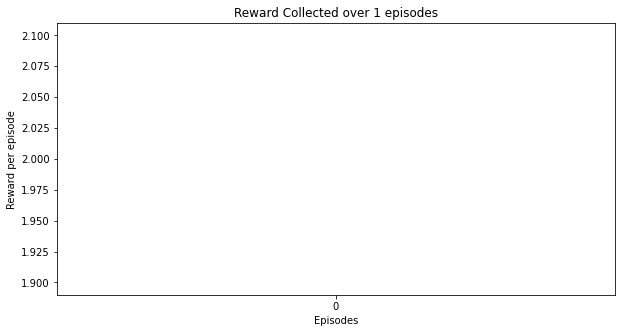

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
x = len(reward_collected)
ax.plot(range(x), reward_collected)
ax.set_title(f"Reward Collected over {x} episodes")
ax.set_xlabel("Episodes")
ax.set_ylabel("Reward per episode")
ax.set_xticks(range(0,x+1,10));